# Calcolo quantistico e ottimizzazione
@ [NesyaLab](https://github.com/NesyaLab)
>
© 2024 [Leonardo Lavagna](https://github.com/leonardoLavagna)


In questo Notebook vedremo come risolvere problemi di ottimizzazione con computer quantistici. Il materiale qui presentato si può consultare e manipolare con [Google Colab](https://colab.research.google.com/) o su un ambiente locale come quelli forniti da [Anaconda](https://www.anaconda.com/) (Jupyter Notebook, VS Code, etc...). Oltre a classici strumenti di programmazione ad alto livello, utilizzeremo il [pacchetto Qiskit](https://www.ibm.com/quantum/qiskit) con i relativi [simulatori](https://qiskit.github.io/qiskit-aer/tutorials/1_aersimulator.html) e alcune librerie di [python](https://www.python.org/) specifiche per l'ottimizzazione come [SciPy](https://scipy.org/).  Se non si sono già installati tali strumenti eseguire innanzitutto i seguenti comandi. Valide alternative sono il pacchetto [Pennylane](https://pennylane.ai/), [Cirq](https://quantumai.google/cirq) o [solutori in Matlab](https://it.mathworks.com/matlabcentral/fileexchange/125425-matlab-support-package-for-quantum-computing).

In [ ]:
!pip install qiskit qiskit-aer qiskit-optimization
!pip install scipy

**Indice**

[Introduzione](#updateTitle=true&folderId=1FIcM057znbGQu1Tx4qgtiIxe8idS0sGA&scrollTo=PvvlWceQSZFf)

[Problemi di ottimizzazione e calcolatori quantistici](#updateTitle=true&folderId=1FIcM057znbGQu1Tx4qgtiIxe8idS0sGA&scrollTo=3zcpq7NAAxlR)

$\quad$ [Problemi QUBO](#updateTitle=true&folderId=1FIcM057znbGQu1Tx4qgtiIxe8idS0sGA&scrollTo=hoAGtgd0Ba-z)

$\quad$ [Il modello di Ising](#updateTitle=true&folderId=1FIcM057znbGQu1Tx4qgtiIxe8idS0sGA&scrollTo=17lxy_LrBPoR)

$\quad$ [Il teorema adiabatico](#updateTitle=true&folderId=1FIcM057znbGQu1Tx4qgtiIxe8idS0sGA&scrollTo=vvi7OONLA8Vv)

[Il QAOA e le sue applicazioni](#updateTitle=true&folderId=1FIcM057znbGQu1Tx4qgtiIxe8idS0sGA&scrollTo=ObL74ee8BfbU)

$\quad$ [MaxCut](#updateTitle=true&folderId=1FIcM057znbGQu1Tx4qgtiIxe8idS0sGA&scrollTo=axE1bYEkThmC)

[Esercizi](#updateTitle=true&folderId=1FIcM057znbGQu1Tx4qgtiIxe8idS0sGA&scrollTo=WzFqV91LRM1k)

[Riferimenti bibliografici](#updateTitle=true&folderId=1FIcM057znbGQu1Tx4qgtiIxe8idS0sGA&scrollTo=y7wZNHXWBlMZ)


## Introduzione

L’ [ottimizzazione](https://en.wikipedia.org/wiki/Mathematical_optimization) è una delle più antiche branche della matematica e formalizza la procedura intuitiva di selezione, secondo dei criteri fissati, di un elemento migliore tra un insieme di possibili alternative. Importanti problemi di ottimizzazione emergono tanto da considerazioni puramente teoriche (e.g. nel calcolo delle variazioni, nella geometria differenziale, nella meccanica razionale) quanto nelle applicazioni (e.g. logistica, apprendimento automatico, finanza quantitativa) e sono tanto complessi da non poter essere risolti in modo esatto o analitico, se non in casi estremamente semplici. In questo senso, il calcolatore è uno strumento imprescindibile per poter lavorare efficacemente in questi campi. Il guaio è che la maggior parte dei problemi più interessanti non ammettono solzioni esatte nemmeno al calcolatore o, peggio, non ammettono nemmeno soluzioni approssimate che il calcolatore riesce a determinare in tempi ragionevoli con un tasso di errore accettabile. Per questa ragione, da quando il [calcolo quantistico](https://en.wikipedia.org/wiki/Quantum_computing) è stato formalizzato nella prima metà degli anni '80, tra i primi problemi che si è cercato di studiare si sono considerati problemi di ottimizzazione. In questo Notebook ci occuperemo di studiare una fra le molte tecniche disponibili per risolvere problemi di ottimizzazione [NP-hard](https://en.wikipedia.org/wiki/NP-hardness) con un [approccio ibrido](https://en.wikipedia.org/wiki/Variational_quantum_eigensolver) in cui parte della soluzione sarà calcolata da un dispositivo quantistico e la restante parte da un dispositivo classico, in modo da bilanciare le difficoltà che i dispositivi classici hanno nell'eleborare questo tipo di problemi con le potenzialità del calcolo quantistico che però risulta essere a sua volta limitato dallo stato primordiale della [tecnologia NISQ](https://en.wikipedia.org/wiki/Noisy_intermediate-scale_quantum_era).

In [2]:
# ESEMPIO 1 PRIMA PARTE
# Soluzione per enumerazione di un semplice problema di ottimizzazione vincolato
# Con valutazione a spanne delle risorse di calcolo necessarie
# Funzione obiettivo (lineare): f(x,y)= 3x+4y
# Vincoli: x>0, y>=0, x+2y<=8, x e y sono interi

import math
import warnings
# Disattivazione degli avvisi per una visualizzazione più pulita
warnings.filterwarnings('ignore')

# Definizione della funzione obiettivo: f(x, y) = 3x + 4y
# Questa funzione calcola il valore della funzione obiettivo dati x e y.
def objective_function(x, y):
    return 3 * x + 4 * y

# Definizione della funzione che verifica i vincoli
# La funzione restituisce True se la soluzione (x, y) soddisfa tutti i vincoli:
# x >= 0, y >= 0, e x + 2y <= 8
def is_feasible(x, y):
    return (x + 2 * y <= 8) and (x >= 0) and (y >= 0)

# Inizializzazione delle variabili per memorizzare la soluzione migliore
# e il valore massimo
best_solution = None
best_value = float('-inf')
iterations = 0

# Ciclo annidato per enumerare tutte le possibili coppie (x, y)
# Si considerano valori interi di x e y compresi tra 0 e 99
for x in range(0, 100):
    for y in range(0, 100):
        iterations += 1
        if is_feasible(x, y):
            value = objective_function(x, y)
            if value > best_value:
                best_value = value
                best_solution = (x, y)

# Calcolo del numero di bit necessari per rappresentare i valori di x e y
# Utilizza il logaritmo base 2 approssimato
bits_x = int(math.log2(100))
bits_y = int(math.log2(100))
total_bits = bits_x + bits_y

# Stima del numero di porte logiche necessarie per la funzione obiettivo e i vincoli
# Assumendo che il numero di porte logiche sia proporzionale al numero di bit
gates_objective = 2 * (bits_x + bits_y)
gates_constraint = 2 * (bits_x + bits_y)
gates_total = gates_objective + gates_constraint

print("Numero di bit (approssimato):", total_bits)
print("Numero di porte logiche (approssimato):", gates_total)
print(f"Soluzione: x = {best_solution[0]}, y = {best_solution[1]}")
print(f"Valore massimo: {best_value}")
print(f"Numero di iterazioni: {iterations}")

Numero di bit (approssimato): 12
Numero di porte logiche (approssimato): 48
Soluzione: x = 8, y = 0
Valore massimo: 24
Numero di iterazioni: 10000


In [3]:
# ESEMPIO 1 SECONDA PARTE
# Valutazione delle risorse NISQ necessarie a risolvere il problema di
# ottimizzazione vincolato

from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

# Creazione di un'istanza del problema quadratico
qp = QuadraticProgram()

# Definizione delle variabili intere x e y con i loro limiti inferiori e superiori
qp.integer_var(name="x", lowerbound=0, upperbound=100)
qp.integer_var(name="y", lowerbound=0, upperbound=100)

# Definizione della funzione obiettivo (massimizzazione): f(x, y) = 3x + 4y
qp.maximize(linear={"x": 3, "y": 4})

# Definizione del vincolo lineare: x + 2y <= 8
qp.linear_constraint(linear={"x": 1, "y": 2}, sense="LE", rhs=8)

# Creazione di un convertitore per trasformare il problema in formato QUBO
qp2qubo = QuadraticProgramToQubo()

# Conversione del problema nel formato QUBO
qubo = qp2qubo.convert(qp)

# Conversione del problema QUBO in un modello di Ising
# Questa rappresentazione è utile per i computer quantistici
qubitOp, offset = qubo.to_ising()

print("Numero di porte quantistiche:", len(qubitOp.paulis))
print("Numero di qubit", qubitOp.num_qubits)

Numero di porte quantistiche: 171
Numero di qubit 18


In [ ]:
# ESEMPIO 1 PARTE FINALE
# Risoluzione simulata quantistica del problema di ottimizzazione vincolato
# Se ci mette diversi minuti è normale...

from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

# Creazione di un'istanza del MinimumEigenOptimizer con QAOA
# QAOA è configurato con:
# - Un Sampler, che esegue simulazioni dei circuiti quantistici
# - COBYLA come ottimizzatore classico per regolare i parametri del QAOA
meo = MinimumEigenOptimizer(QAOA(sampler=Sampler(), optimizer=COBYLA(maxiter=100)))

# Risoluzione del problema di ottimizzazione precedentemente definito (qp)
# Utilizza l'algoritmo configurato sopra
result = meo.solve(qp)

print(result.prettyprint())

L' ottimizzazione classica, per quanto vasta e ricca di difficoltà, si può schematicamente riassumere in termini semplici: data una *funzione obiettivo*, che tanto per fissare le idee considereremo essere una [funzione scalare](https://en.wikipedia.org/wiki/Scalar_field) $f:\Omega\subset \mathbb{R}^n\to \mathbb{R}$ definita su un [aperto](https://en.wikipedia.org/wiki/Open_set) $\Omega$ di $\mathbb{R}^n$ a valori reali, lo scopo è quello di determinare un vettore $x^*$ che risolve il problema (eventualmente vincolato, eventualmente di massimo, Esercizio 1)
$$
f(x^*)=\min_{x\in \Omega} f(x)\,.
$$
Se $f$ è sufficientemente regolare, $x^*$ si può ricercare fra i punti della [chiusura](https://en.wikipedia.org/wiki/Closure_(topology)) di $\Omega$ che soddisfano la condizione
$$
\nabla f(x)=0\,,
$$
(ed eventuali vincoli) dove [l'operatore $\nabla$](https://en.wikipedia.org/wiki/Del) si può valutare al calcolatore sia in modo esatto (quando sono note formule chiuse per le derivate delle funzione obiettivo) o in modo approssimato con opportuni metodi numerici (e.g. interpolazione, discretizzazione con elementi finiti, calcolo simbolico). Le cose si complicano notevolmente quando $f$ non è differenziabile, oppure quando $\Omega$ non è un aperto, ma un [sottoinsieme discreto](https://en.wikipedia.org/wiki/Discrete_space). In effetti, molti problemi di straordinaria importanza applicativa (e.g. il problema del commesso viaggiatore, il  ricoprimento degli insiemi, il problema del taglio massimo in un grafo) coinvolgono proprio casi in cui non si può calcolare direttamente il gradiente della funzione obiettivo e in cui il numero di valutazioni di $f$ necessarie a determinarne i punti critici cresce esponenzialmente nella dimensione di $\Omega$.

In questo Notebook ci concentreremo su problemi di [ottimizzazione combinatoria](https://en.wikipedia.org/wiki/Combinatorial_optimization) in cui il dominio $\Omega$ è un sottoinsieme discreto, tipicamente $\Omega\subset \mathbb{Z}^n$, e la funzione obiettivo $f$ può assumere un numero esponenziale di valori (esponenziale nella dimensione $n$ dei dati). Grazie alle [proprietà della teoria dei quanti](https://en.wikipedia.org/wiki/Mathematical_formulation_of_quantum_mechanics), si sono sviluppati tutta una serie di algoritmi quantistici che in certi casi concreti hanno la dimostrabile capacità di superare qualsiasi controparte classica attualmente nota.

In [4]:
# ESEMPIO 2
# Soluzione di un semplice problema di ottimizzazione con il teorema di Fermat
# Funzione obiettivo (non lineare): f(x,y)= x^2+y^2-4x-6y
# Gradiente: (2x-4,2y-6)

import numpy as np

# Definizione della funzione obiettivo: f(x, y) = x^2 + y^2 - 4x - 6y
# Questa funzione rappresenta il problema di ottimizzazione da risolvere
def objective_function(x, y):
    return x**2 + y**2 - 4*x - 6*y

# Definizione del gradiente della funzione obiettivo
# Il gradiente è un array contenente le derivate parziali rispetto a x e y:
# [∂f/∂x, ∂f/∂y] = [2x - 4, 2y - 6]
def gradient(x, y):
    return np.array([2*x - 4, 2*y - 6])

# Funzione per risolvere il problema trovando i punti in cui il gradiente si annulla
def solve_gradient_zero():
    grad_zero_x = 4 / 2
    grad_zero_y = 6 / 2
    x, y = grad_zero_x, grad_zero_y
    f_min = objective_function(x, y)
    return x, y, f_min

# Chiamata alla funzione per trovare la soluzione ottimale
x_opt, y_opt, f_min = solve_gradient_zero()

print(f"Soluzione: x = {x_opt}, y = {y_opt}")
print(f"Valore minimo: {f_min}")

Soluzione: x = 2.0, y = 3.0
Valore minimo: -13.0


## Problemi di ottimizzazione e calcolatori quantistici

Nell'ambito dei problemi di ottimizzazione combinatoria, in cui tipicamente $\Omega\subset \mathbb{Z}^n$, ci si può restringere al caso di variabili binarie. Infatti, se $x\in \Omega$ è un vettore a componenti intere $x=(x_1,\dots, x_n)\in \mathbb{Z}^n$, rappresentando ogni componente $x_i\in \mathbb{Z}$ in base due, e si scrive $z_i=(x_i)_2$ per ogni $i=1,\dots n$, si passa da $x$ ad una stringa binaria $z=(x)_2$ con componenti $z=(z_1,\dots, z_n)$. Per semplicità di notazione indicheremo una stringa binaria $z$ con la giustapposizione dei simboli $z=z_1z_2\dots z_n$ (cf. Esercizio 2). Chiaramente, $z\in\{0,1\}^N$ è una successione di $N>n$ bit. In questo contesto la funzione obiettivo $f:\{0,1\}^N\to \mathbb{R}$ può assumere un numero esponenziale (in $N$) di valori $f(z)$, uno per ciascun assegnazione binaria dei bit in $z$. Inoltre, non è ben definito il rapporto incrementale
$$
\Delta_h f=\frac{1}{h}(f(z+h)-f(z))
$$
per ogni $h\in \mathbb{R}$ e dunque non si possono applicare tecniche classiche basate sull'analisi del gradiente e uno studio approfondito della funzione di costo è necessario caso per caso. Classicamente esistono numerose tecniche di analisi, essenzialmente basate su: enumerazione (quando possibile) dei valori, rilassamento delle variabili, approssimazione di $f$ (e.g. mediante serie di Taylor), metodi stocastici, o combinazione delle precedenti. Come vedremo, in un certo senso, gli algoritmi di ottimizzazione quantistica racchiudono tutte queste tecniche approssimate in un unica struttura di calcolo.

In [5]:
# ESEMPIO 3
# Soluzione del problema dell'Esempio 1 con un metodo del gradiente ascendente

def objective_function(x, y):
    return 3 * x + 4 * y

def is_feasible(x, y):
    return (x + 2 * y <= 8) and (x >= 0) and (y >= 0)

def gradient():
    return np.array([3, 4])

# Funzione per proiettare (x, y) nell'insieme ammissibile, rispettando i vincoli
def project(x, y):
    if x < 0: x = 0
    if y < 0: y = 0
    if x + 2 * y > 8:
        y = min(y, (8 - x) / 2)
    return x, y

# Implementazione del metodo del gradiente ascendente
# Inizia da un punto iniziale e segue il gradiente per massimizzare la funzione obiettivo
def gradient_ascent(starting_point, learning_rate, iterations):
    x, y = starting_point
    for i in range(iterations):
        grad = gradient()
        x += learning_rate * grad[0]
        y += learning_rate * grad[1]
        x, y = project(x, y)
    return x, y

# Impostazione dei parametri iniziali
starting_point = (0, 0)
learning_rate = 0.1
iterations = 50

# Esecuzione del metodo del gradiente ascendente
x_opt, y_opt = gradient_ascent(starting_point, learning_rate, iterations)
max_value = objective_function(x_opt, y_opt)

print(f"Soluzione (rilassata): x = {x_opt:.2f}, y = {y_opt:.2f}")
print(f"Valore massimo: {max_value:.2f}")

Soluzione (rilassata): x = 15.00, y = -3.50
Valore massimo: 31.00


### Problemi QUBO

Il caso più semplice che si può iniziare ad analizzare è dato dai cosiddetti [problemi QUBO](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization) (Quadratic Unconstrained Optimization Problems) dove $\Omega=\{0,1\}^N$ e la funzione di costo
$$
f(z)=\langle z|\mathbf{a}z\rangle + \langle b|z\rangle + c
$$
è una forma quadratica determinata da una matrice dei pesi $\mathbf{a}=(a_{ij})\in \mathbb{R}^{N\times N}$ e due vettori colonna $b,c\in\mathbb{R}^N$. Non è difficile notare (cf. Esercizio 3) che si può porre $c=0$ senza ledere la generalità del problema, mentre in generale $b\ne 0$ e $\mathbf{a}$ si considera triangolare superiore (equivalentemente, simmetrica e non degenere, cf. Esercizio 4). Esplicitamente
$$
f(z)=\sum_{i,j}a_{ij}z_iz_j+\sum_i b_iz_i\,.
$$

In [6]:
# ESEMPIO 4
# Problemi QUBO e non QUBO (sintassi simile a quella di Ciplex)

# Funzione per verificare se un problema è in formato QUBO
def is_qubo(problem):
    for key, coefficient in problem.items():
        if not (isinstance(key, tuple) and len(key) == 2 and all(isinstance(k, int) for k in key)):
            return False
        if not isinstance(coefficient, (int, float)):
            return False
    return True

# Definizione di un problema in formato QUBO
qubo_problem = {
    (0, 0): 3,
    (1, 1): 4,
    (0, 1): -2,
}

# Definizione di un problema NON in formato QUBO (include termini non validi)
non_qubo_problem = {
    (0, 0): 3,
    (1, 1): 4,
    (0, 1): -2,
    (2, 2): 5,
    (0, 2): 3,
    (0, 1, 2): 1
}

print(f"Il qubo_problem è QUBO?: {is_qubo(qubo_problem)}")
print(f"Il non_qubo problem è QUBO?: {is_qubo(non_qubo_problem)}")

Il qubo_problem è QUBO?: True
Il non_qubo problem è QUBO?: False


Trattandosi di variabili binarie, $f$ si può direttamente calcolare con dispositivi classici, ma altrettanto non si può fare su dispositivi quantistici che operano su vettori di opportuni [spazi di Hilbert](https://en.wikipedia.org/wiki/Mathematical_formulation_of_quantum_mechanics) (qubit) con [operatori unitari](https://en.wikipedia.org/wiki/Quantum_logic_gate) (porte quantistiche).

### Il modello di Ising

Il [modello di Ising](https://en.wikipedia.org/wiki/Ising_model) permette di mappare un problema QUBO in un problema che un computer quantistico può risolvere (simulazione Hamiltoniana). Il primo passo di questa trasformazione consiste nel considerare l'applicazione biunivoca, in cui s'introduce la notazione degli apici per comodità (i.e. $z_i=z^{(i)}$)
$$
z^{(i)}\to z'^{(i)}= 2z^{(i)}-1
$$
per ogni $i=1,\dots, n$, che trasforma i bit $z_i=z^{(i)}$ in variabili con segno in $z'^{(i)}\in \{\pm 1\}$. Siccome i valori $\pm 1$ corrispondono precisamente agli autovalori [delle matrici di Pauli](https://en.wikipedia.org/wiki/Pauli_matrices), e ogni [misura al termine di un calcolo quantistico](https://en.wikipedia.org/wiki/Measurement_in_quantum_mechanics) restituisce proprio gli autovalori corrispondenti alle osservabili che generano le unitarie considerate nell'evoluzione scandita durante il calcolo secondo la [regola di Born](https://en.wikipedia.org/wiki/Born_rule), il mapping ideale è proprio quello di associare a ciascuna variabile $z$ un insieme $\sigma$ di matrici di Pauli (Esercizio 5 ed Esercizio 6).

Per capire quali fra le osservabili di Pauli conviene considerare, bisogna analizzare più da vicino la funzione di costo in relazione al problema che si vuole risolvere. In generale, con la trasformazione $f(z)\to f(z')$ per $z'=2z-1$, si può pensare che le variabili con segno $z'^{(i)}$ che determinano la stringa $z'$ siano dei termini di interazione per un sistema fisico di tipo cristtalografico dove i pesi $a_{ij}$ rappresentano l'intensità dell'interazione a coppie e i termini $b_i$ della parte lineare di $f$ siano l'equivalente di un campo esterno che agisce su ciascun elemento. In effetti, esiste una corrispondenza biunivoca fra funzioni obiettivo di tipo QUBO in coordinate $z'$ e Hamiltoniane relative a configurazioni di spin su una griglia (cf. Esercizio 7).

A questo punto il metodo per determinare le osservabili di Pauli è chiaro: la funzione obiettivo $f(z')$ corrisponde all'[Hamiltoniana](https://en.wikipedia.org/wiki/Hamiltonian_(quantum_mechanics)) di un sistema di spin in cui i termini d'interazione mista sono determinati da una matrice di Pauli, ad esempio
$$
\boldsymbol{\sigma}_z^{(i)}=\begin{pmatrix}1 & 0\\ 0 & -1 \end{pmatrix}
$$
e il termine di campo esterno da una matrice di Pauli che non commuta con le precedenti (cf. Esercizio 8), ad esempio
$$
\boldsymbol{\sigma}_x^{(i)}=\begin{pmatrix}0 & 1\\ 1 & 0 \end{pmatrix}\,.
$$
Con queste notazioni si ha la funzione obiettivo quantistica
$$
f(\sigma)=\sum_{ij}a_{ij}\boldsymbol{\sigma}_z^{(i)}\otimes \boldsymbol{\sigma}_z^{(j)}+\sum_ib_i\boldsymbol{\sigma}_x^{(i)}\,,
$$
che rappresenta l'osserrvabile Hamiltoniana (Esercizio 9) di un sistema di spin (qubit). Forme più generali in cui compaiono interazioni multi-locali (e.g. interazioni a tre a tre o a quattro a quattro) sono possibili, così come casi in cui il termine di campo esterno coinvolge diversi operatori di Pauli, ma ciò esula dal perimetro dei problemi QUBO.

In [7]:
# ESEMPIO 5
# Mapping da QUBO a Ising

# Funzione per convertire un problema QUBO in un modello di Ising
def qubo_to_ising(Q):
    b = {}
    A = {}
    offset = 0
    for (i, j), A_ij in A.items():
        if i == j:
            b[i] = A_ij
        else:
          A[(min(i, j), max(i,j))] = A_ij / 4
    for i in A:
        if isinstance(i, tuple) and i[0] == i[1]:
          offset += A[i]/4
    for i in A:
        if isinstance(i, tuple) and i[0] != i[1]:
          if (min(i),max(i)) in J:
             offset += A[i]/4
    return b, A, offset

# Definizione di un problema QUBO per il test
qubo_problem = {
    (0, 0): -1,
    (1, 1): -1,
    (0, 1): 2
}

# Conversione del problema QUBO in Ising
b, A, offset = qubo_to_ising(qubo_problem)

# Formattazione dell'hamiltoniana di Ising in notazione simbolica
f_sigma = "".join(f"({val})*σ^({key}) + " for key, val in b.items()) + " + ".join(
    f"({val})*σ^({key[0]})σ^({key[1]})" for key, val in A.items())

print("Termini lineari di Ising:", b)
print("Termini quadratici di Ising:", A)
print("Offset (termine costante):", offset)
print("Hamiltoniana di Ising:", f_sigma)

Termini lineari di Ising: {}
Termini quadratici di Ising: {}
Offset (termine costante): 0
Hamiltoniana di Ising: 


### Il teorema adiabatico

Abbiamo visto che per risolvere un problema di ottimizzazione combinatoria (di tipo QUBO) si scrive la funzione obiettivo $f$ in termini di bit $f=f(z)$, poi la si trasforma in coordinate con segno $f=f(z')$ con $z'=2z-1$ e si associa a ciascuna variabile una matrice di Pauli secondo il modello di Ising $f=f(\sigma)$. Una volta completato questo passo di codifica bisogna risolvere concretamente il problema di ottimizzazione con il computer quantistico, cioè descrivere il modo in cui la funzione obiettivo inizializzata in un certo stato $|\psi_0\rangle$ possa essere portata allo stato $|\psi^*\rangle$ corrispondente al minimo dell'Hamiltoniana di Ising. In effetti, conoscendo $|\psi^*\rangle$ si può tornare indietro associando a ciascuna delle sue componenti una variabile con segno e quindi il corrispondente bit $i$-esimo della soluzione. In questo modo, la configurazione di minima energia per $f(\sigma)$ determina la soluzione del problema di ottimizzazione QUBO $f(z^*)=\min_\Omega f(z)$.

Il modo con cui si può passare da $f(\sigma)$ al suo minimo autostato con un computer quantistico è un [processo adiabatico](https://en.wikipedia.org/wiki/Adiabatic_theorem): si inizializza $f=f(\sigma)$ in $\sigma$, dopodichè si considera una perturbazione piccola di $f$ per un tempo di evoluzione $T\gg 1$. Se $T$ è abbastanza grande e la perturbazione rimane abbastanza vicina (come Hamiltoniana) a $f$ durante l'evoluzione, allora il graduale mutamento delle condizioni consente al sistema di adattare la sua configurazione, quindi la densità di probabilità corrispondente alla misurazione del sistema che evolve viene modificata dal processo in modo controllato.


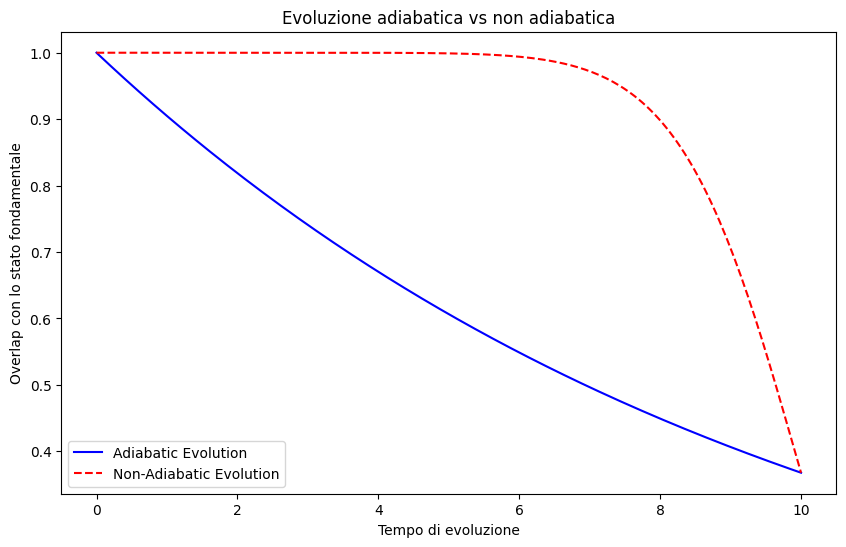

In [8]:
# ESEMPIO 6
# Evoluzione adiabatica vs evoluzione non adiabatica
# Si analizza come varia l'overlap con lo stato fondamentale nel tempo di evoluzione.

import matplotlib.pyplot as plt

# Definizione dell'Hamiltoniana del sistema in funzione del tempo
# t: tempo corrente, T: tempo totale di evoluzione, J: costante di accoppiamento
# Restituisce i coefficienti temporali h_t e J dell'Hamiltoniana
def hamiltonian(t, T, J=1.0):
    h_t = 1.0 - t / T
    return h_t, J

# Simulazione dell'evoluzione adiabatica
# T: tempo totale di evoluzione, steps: numero di passi temporali
# Calcola l'overlap con lo stato fondamentale in ogni passo temporale
def adiabatic_evolution(T, steps=100):
    overlaps = []
    for t in np.linspace(0, T, steps):
        h_t, J = hamiltonian(t, T)
        overlap = np.exp(-t / T)
        overlaps.append(overlap)
    return overlaps

# Simulazione dell'evoluzione non adiabatica
# T: tempo totale di evoluzione, steps: numero di passi temporali
# Calcola l'overlap con lo stato fondamentale in ogni passo temporale
def non_adiabatic_evolution(T, steps=100):
    overlaps = []
    for t in np.linspace(0, T, steps):
        h_t, J = hamiltonian(t, T)
        overlap = np.exp(- (t / T) ** 10)
        overlaps.append(overlap)
    return overlaps

# Parametri della simulazione
T = 10
steps = 200

# Calcolo degli overlap per evoluzione adiabatica e non adiabatica
adiabatic_overlaps = adiabatic_evolution(T, steps)
non_adiabatic_overlaps = non_adiabatic_evolution(T, steps)

# Visualizzazione dei risultati
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, steps), adiabatic_overlaps, label="Adiabatic Evolution", color='b')
plt.plot(np.linspace(0, T, steps), non_adiabatic_overlaps, label="Non-Adiabatic Evolution", color='r', linestyle='--')

plt.title("Evoluzione adiabatica vs non adiabatica")
plt.xlabel("Tempo di evoluzione")
plt.ylabel("Overlap con lo stato fondamentale")
plt.legend()
plt.show()

Supponiamo di preparare un sistema quantistico nello stato fondamentale $|\psi_0\rangle$ di una data Hamiltoniana $H$ (ossia, $|\psi_0\rangle$ è l'autostato che realizza il minimo di $H$), e poi modifichiamo $H$ gradualmente nel tempo. Se il cambiamento è sufficientemente lento, allora il sistema rimane nello stato fondamentale istantaneo con alta probabilità. L' Hamiltoniana dipendente dal tempo è descritta da una famiglia di [operatori autoaggiunti](https://en.wikipedia.org/wiki/Hermitian_adjoint) $\{H(t)\}_{t \in [0,T]}$ nello spazio di Hilbert del sistema quantistico considerato. La dinamica del sistema preparato nello stato fondamentale $|\psi_0\rangle$ è descritta dalla soluzione dell'[equazione di Schrödinger](https://en.wikipedia.org/wiki/Schr%C3%B6dinger_equation):
$$
i\hbar \frac{d}{dt} |\psi(t)\rangle = H(t)|\psi(t)\rangle \quad t \in [0, T],
$$
con condizione iniziale $|\psi(0)\rangle = |\psi_0\rangle$. Possiamo riparametrizzare l'Hamiltoniana dipendente dal tempo come $\tilde{H}(s) := H(Ts)$ con $s \in [0, 1]$. Per ogni $s \in [0, 1]$ si ha il seguente [problema agli autovalori](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors):
$$
\tilde{H}(s)|ls\rangle = E_l(s)|ls\rangle,
$$
dove $E_0(s)$ è il minimo dello spettro di $\tilde{H}(s)$ e $|0 s\rangle$ è il corrispondente autovettore, ossia lo stato fondamentale. Supponiamo che lo stato iniziale sia non degenere.

**Teorema (adiabatico) .** Se $\lambda(s) := E_1(s) - E_0(s) > 0$ per ogni $s \in [0, 1]$, allora:
$$
\lim_{T \to +\infty} |\langle 0 1|\psi(T)\rangle| = 1,
$$
dove $|\psi(T)\rangle$ è la soluzione dell'equazione di Schrödinger descritta in precedenza, con condizione iniziale $|\psi(0)\rangle = |00\rangle$, calcolata in $t = T$.

L'esistenza di un gap spettrale non nullo $\lambda$ garantisce che lo stato del sistema in evoluzione rimanga nello stato fondamentale di $H(t)$, per ogni $t \in [0, T]$, se il tempo di evoluzione è lungo.

**Osservazione .** Per valutare quanto grande debba essere $T$ affinché la probabilità di rimanere nello stato fondamentale sia accettabile, si può usare la seguente stima approssimativa, anche se esistono condizioni adiabatiche più raffinate:
$$
T \gg \frac{\max_s \| \frac{d}{ds}\tilde{H}(s) \|_{\text{op}}}{[\min_s \lambda(s)]^2},
$$

dove $\| \cdot \|_{\text{op}}$ è la [norma operatore](https://en.wikipedia.org/wiki/Operator_norm).



La struttura generale di un calcolo quantistico adiabatico è quindi la seguente:

- Un sistema quantistico è preparato nello stato fondamentale noto di una Hamiltoniana iniziale $H_I$ tale che $[H_I, f(\sigma)] \neq 0$, cioè che [non commuta](https://en.wikipedia.org/wiki/Commutator) con l'Hamiltoniana di Ising.
- Una variazione temporale dell'Hamiltoniana da $H_I$ a $f(\sigma)$ è implementata secondo: $H(t) = (1 - s(t))H_I + s(t)f(\sigma)$ con $t \in [0, T]$ dove $T$ soddisfa le condizioni del teorema adiabatico, $s : [0, \tau] \to [0, 1]$ è una funzione monotona regolare tale che $s(0) = 0$ e $s(T) = 1$, e $f(\sigma)$ è l'Hamiltoniana del problema.
- Un processo di misura del sistema quantistico evoluto.


Il problema da risolvere è codificato in $f(\sigma)$ e il suo stato fondamentale rappresenta la soluzione. Per il teorema adiabatico, il processo di misurazione finale è effettuato sullo stato fondamentale di $f$ con alta probabilità.

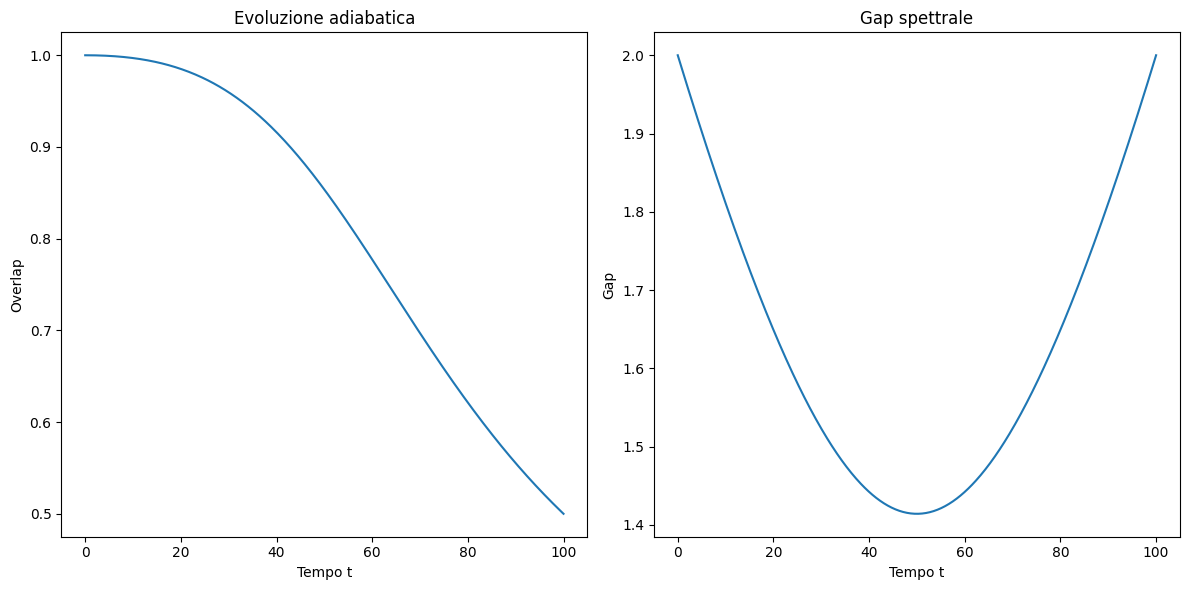

In [9]:
# ESEMPIO 7
# Simulazione adiabatica
# La simulazione risolve l'equazione di Schrödinger per un sistema con Hamiltoniana
# dipendente dal tempo.

from scipy.linalg import expm
from scipy.integrate import solve_ivp

# Costanti fisiche
hbar = 1.0
T = 100.0
steps = 500
n_points = 100

# Definizione delle Hamiltoniane istantanee H0 e H1
# Hamiltoniana di base, rappresenta una matrice diagonale con valori -1 e 1
def H0():
    return np.array([[1, 0], [0, -1]])

# Hamiltoniana finale, rappresenta una matrice di Pauli X
def H1():
    return np.array([[0, 1], [1, 0]])

# Funzione per calcolare l'Hamiltoniana istantanea H(t)
# t: tempo corrente, T: tempo totale di evoluzione
def H_t(t, T):
    s = t / T
    return (1 - s) * H0() + s * H1()

# Funzione per calcolare lo stato fondamentale e il gap spettrale istantaneo
def instantaneous_eigenstate(t, T):
    H = H_t(t, T)
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    ground_state = eigenvectors[:, 0]
    gap = eigenvalues[1] - eigenvalues[0]
    return eigenvalues[0], ground_state, gap

# Funzione per risolvere l'equazione di Schrödinger
# t: tempo corrente, psi: stato quantistico, T: tempo totale di evoluzione
def schrodinger_eq(t, psi, T):
    H = H_t(t, T)
    return -1j / hbar * H @ psi

# Calcolo dello stato fondamentale e gap iniziale al tempo t=0
_, psi0, _ = instantaneous_eigenstate(0, T)

# Generazione dei tempi di evoluzione
times = np.linspace(0, T, steps)

# Risoluzione dell'equazione di Schrödinger usando il metodo di Runge-Kutta (solve_ivp)
sol = solve_ivp(lambda t, psi: schrodinger_eq(t, psi, T), [0, T], psi0, t_eval=times, vectorized=True)

# Stato evoluto del sistema in funzione del tempo
evolved_states = sol.y.T

# Calcolo dell'overlap con lo stato fondamentale e del gap spettrale lungo l'evoluzione
overlaps = []
spectral_gaps = []

for t_idx, t in enumerate(times):
    _, ground_state, gap = instantaneous_eigenstate(t, T)
    spectral_gaps.append(gap)
    overlaps.append(np.abs(np.vdot(ground_state, evolved_states[t_idx])) ** 2)

# Visualizzazione dei risultati
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(times, overlaps)
plt.xlabel("Tempo t")
plt.ylabel("Overlap")
plt.title("Evoluzione adiabatica")

plt.subplot(1, 2, 2)
plt.plot(times, spectral_gaps)
plt.xlabel("Tempo t")
plt.ylabel("Gap")
plt.title("Gap spettrale")

plt.tight_layout()
plt.show()

## Il QAOA e le sue applicazioni

Il Quantum Approximate Optimization Algorithm (QAOA) è uno dei possibili algoritmi quantistici che implementano l'evoluzione adiabatica per risolvere problemi QUBO. Come tutti gli algoritmi quantistici esso è descritto da due ingredienti principali:

- Un insieme di operatori unitari (porte quantistiche);
- Delle regole di moltiplicazione fra gli operatori unitari selezionati (circuito quantistico).

Come abbiamo visto gli operatori unitari da considerare sono quelli relativi alle osservabili di Pauli nell'Hamiltoniana di Ising $f(\sigma)$, mentre le regole di moltiplicazione sono descritte dal teorema adiabatico. In questa sezione, per coerenza con la notazione dei [circuiti quantistici parametrizzati](https://en.wikipedia.org/wiki/Quantum_circuit)
il ruolo del tempo di evoluzione sarà giocato dalla somma di due parametri angolari, uno per ciascun termine nell'Hamiltoniana di Ising.

Dato un numero di layer $p \geq 1$, insieme a $p$ angoli $\gamma_k \in (0,2\pi]$ e $p$ angoli $\beta_k \in (0,\pi]$, il QAOA opera come segue:

- Si sceglie una codifica di base $z \to |z\rangle$ e si prepara uno stato iniziale $|\psi_0\rangle$ come una sovrapposizione uniforme $|\psi_0\rangle = \frac{1}{\sqrt{2^N}}\sum_{z}|z\rangle$ (Esercizio 10),
- Si mappa $f(z)$ in $f(\sigma)$ promuovendo ogni variabile binaria a una porta di Pauli $\boldsymbol{\sigma}_z^{(i)}$, quindi si definisce il seguente operatore unitario considerando, per ogni intero $k=1,\dots, p$, una rotazione $U_f(\gamma_k) = e^{-i\gamma_k f(\sigma)}$ che è un prodotto di $m$ termini (Esercizio 11).
- Per ogni $k=1,\dots, p$, si sceglie un operatore di mixing $H_I$ che non commuta con $U_f$, in questo caso un'altra rotazione $H_I(\beta_k)=e^{-i\beta_k\sum_{j=1}^n \boldsymbol{\sigma}_x^{(j)}}$ definita come un prodotto di $N$ termini (Esercizio 13), ognuno dei quali è una porta di Pauli $\boldsymbol{\sigma}_x$ con angolo di rotazione $\beta_k$;
- Si definisce lo stato $|\gamma\beta\rangle := H_I(\beta_p)U_f(\gamma_p)\prod_{i=1}^{p-1}[H_I(\beta_{p-i})U_f(\gamma_{p-i})]|\psi_0\rangle$ come lo stato evoluto e si considera $F_p$, il valore atteso $F_p(\gamma,\beta):=\langle \gamma\beta| f(\sigma)\ |\ \gamma\beta\rangle$.
- Eventualmente, per migliorare l'approssimazione della soluzione si passa $F_p$ a un ottimizzatore classico per ottenere un insieme aggiornato di parametri $\gamma^*,\beta^*$ e si ripete il processo a partire dai passi precedenti, aggiornando il numero di livelli $p\to p+1$.


### MaxCut

Come applicazione del QAOA consideriamo il [problema del taglio massimo in un grafo](https://en.wikipedia.org/wiki/Maximum_cut) (MaxCut). Consideriamo un grafo $(V, {E})$ con $n$ vertici (nodi) $v_i \in  {V}$ e $m \leq \frac{n(n-1)}{2}$ archi non orientati $\{i,j\} \in  {E}$. Ricordiamo che un taglio in $\Gamma$ è una partizione di $ {V}$ in due insiemi $ {S}$ e $ {V}- {S}$ tale che l'insieme degli archi $ {E}$ abbia un sottoinsieme $ {E}_\mathrm{cut}$ della forma $ {E}_\mathrm{cut} = \{\{i,j\} \ : \ v_i \in  {S}, v_j \in { {V}- {S}}\}$. Un taglio massimo, o MaxCut, è un taglio con $ {E}_\mathrm{cut}$ massimale.  Il problema MaxCut può essere esteso a grafi con archi pesati; in tal caso si parla di *MaxCut pesato*, e la funzione di costo generale del problema è:
$$
f(z) = \sum_{i<j} w_{ij}(1-z_i z_j),
$$
dove $w_{ij} = w_{ji} > 0$ è il peso associato all'arco $\{i,j\}$ tra il nodo $v_i$ e il nodo $v_j$, $z_i = 1$ quando $v_i \in  {S}$, $z_i = 0$ altrimenti, ${i \in \{1, \dots, n\}}$. Chiaramente, MaxCut è un caso particolare di MaxCut pesato con $w_{ij} = 1$ per ogni arco. È noto che il problema MaxCut è NP-hard, tuttavia sono state trovate molte soluzioni approssimate classiche, in particolare nell'ambito della programmazione semidefinita.


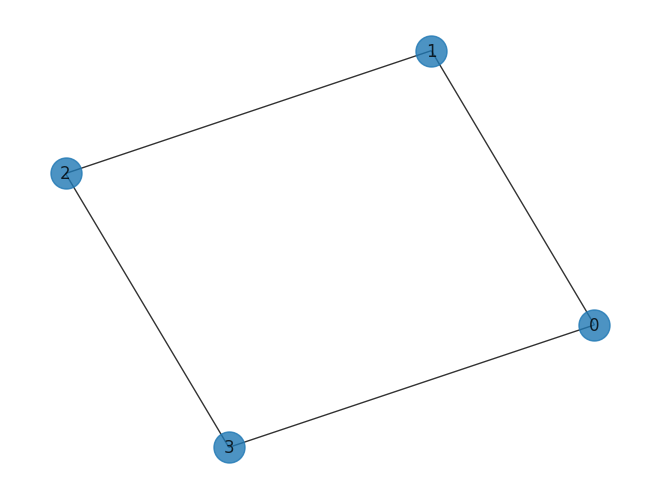

In [10]:
# EEMPIO 8 PRIMA PARTE
# QAOA per MaxCut

import networkx as nx

# Definizione di un grafo semplice per calcolarne il MaxCut con QAOA
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [11]:
# ESEMPIO 8 SECONDA PARTE

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit import Parameter

# Numero di qubit, inizializzazione di un circuito
n_qb = 4
qubit = QuantumRegister(n_qb)
qc = QuantumCircuit(qubit)

# Inizializza la sovrapposizione uniforme
qc.h(qubit)
qc.barrier()

# Definisce il termine quadratico dell'Hamiltoniana del problema
gamma = Parameter("$\\gamma$")
for pair in list(G.edges()):
    qc.rzz(2 * gamma, pair[0], pair[1])

# Aggiunge il mixer H_I
qc.barrier()
beta = Parameter("$\\beta$")
for i in range(0, n_qb):
    qc.rx(2 * beta, i)

# Misura finale del circuito
qc.measure_all()

# Stampa il circuito
qc.draw()

┌───┐ ░                                                    »
  q0_0: ┤ H ├─░──■────────────────■────────────────────────────────»
        ├───┤ ░  │ZZ(2*$\gamma$)  │                                »
  q0_1: ┤ H ├─░──■────────────────┼────────────────■───────────────»
        ├───┤ ░                   │                │ZZ(2*$\gamma$) »
  q0_2: ┤ H ├─░───────────────────┼────────────────■───────────────»
        ├───┤ ░                   │ZZ(2*$\gamma$)                  »
  q0_3: ┤ H ├─░───────────────────■────────────────────────────────»
        └───┘ ░                                                    »
meas: 4/═══════════════════════════════════════════════════════════»
                                                                   »
«                          ░ ┌───────────────┐ ░ ┌─┐         
«  q0_0: ──────────────────░─┤ Rx(2*$\beta$) ├─░─┤M├─────────
«                          ░ ├───────────────┤ ░ └╥┘┌─┐      
«  q0_1: ──────────────────░─┤ Rx(2*$\beta$) ├─░──╫─┤M├──────
«                          ░ ├───────────────┤ ░  ║ └╥┘┌─┐   
«  q0_2: ─■────────────────░─┤ Rx(2*$\beta$) ├─░──╫──╫─┤M├───
«         │ZZ(2*$\gamma$)  ░ ├───────────────┤ ░  ║  ║ └╥┘┌─┐
«  q0_3: ─■────────────────░─┤ Rx(2*$\beta$) ├─░──╫──╫──╫─┤M├
«                          ░ └───────────────┘ ░  ║  ║  ║ └╥┘
«meas: 4/═════════════════════════════════════════╩══╩══╩══╩═
«                                                 0  1  2  3

In [12]:
# ESEMPIO 8 TERZA PARTE

from scipy.optimize import minimize
from qiskit import transpile
from qiskit_aer import Aer

# Wrapper per passare i risultati dell'esecuzione del QAOA
# ad un ottimizzatore classico (scipy.optimize)
def cost_function(parameters, qc):
    backend = Aer.get_backend('qasm_simulator')
    bound_qc = qc.assign_parameters({gamma: parameters[0], beta: parameters[1]})
    t_qc = transpile(bound_qc, backend=backend)
    job = backend.run(t_qc, shots=1024)
    counts = job.result().get_counts()
    expectation_value = 0
    for outcome, frequency in counts.items():
        expectation_value += int(outcome, 2) * frequency / 1024
    return expectation_value

# Parametri iniziali per QAOA
initial_point = [0.1, 0.1]

# Step di ottimizzazione classica
res = minimize(cost_function, initial_point, method='COBYLA', args=(qc))

print("Risultato:", res.fun)
print("Parametri ottimali:", res.x)

Risultato: 7.458984375
Parametri ottimali: [-0.78059248  1.79417202]


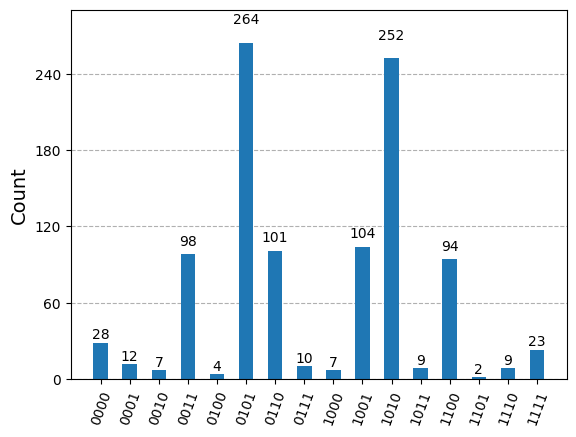

In [13]:
# ESEMPIO 8 PARTE FINALE

from qiskit.visualization import plot_histogram

# Esecuzione del circuito del QAOA con corrispondente
# risultato che verrà letto dall'ottimizzatore classico
backend = Aer.get_backend('qasm_simulator')
bound_qc = qc.assign_parameters({gamma: -0.48489768, beta: 1.91114874})
t_qc = transpile(bound_qc, backend=backend)
job = backend.run(t_qc, shots=1024)
counts = job.result().get_counts()
plot_histogram(counts)

## Esercizi


*Esercizio 1 .* Dimostrare che è possibile passare da un problema di minimo ad uno di massimo semplicemente cambiando segno alla funzione obiettivo. Dimostrare inoltre che un problema di ottimizzazione vincolato si può trasformare in un problema di ottimizzazione non vincolato "scaricando" i vincoli nella funzione obiettivo. Concretamente dimostrare che risolvere
$$
\min x_1^2+x_2^2 \quad x\in \Omega=\{x_1+x_2-1\leq 0, x_1-x_2=0\}
$$
è equivalente a risolvere (con il [metodo delle penalità](https://en.wikipedia.org/wiki/Penalty_method))
$$
\min x_1^2+x_2^2+a_1\max(0, x_1+x_2-1)^2+a_2(x_1-x_2)^2\,.
$$
*Esercizio 2 .* Se $x\in \mathbb{Z}^n$ viene trasformato in una stringa binaria $z=z_1z_2\dots z_n$ con $z_i=(x_i)_2$, quante cifre binarie contiene la stringa $z$? È anche interessante notare che definendo $\omega$ la stringa vuota, e l'operazione $z*w=zw$ tra stringhe data dalla giustapposizione, si ottiene un [monoide](https://en.wikipedia.org/wiki/Monoid), come mai? Questo monoide in algebra è particolarmente interessante vista la sua relazione con i [gruppi liberi](https://en.wikipedia.org/wiki/Free_group)...

*Esercizio 3 .* Dimostrare che in un problema QUBO si può sempre porre $c=0$. Inoltre tale fattore costante è ininfluente in un calcolo quantistico, come mai? [Suggerimento. Una funzione obiettivo QUBO è sostanzialmente un parabiloide a coordinate binarie.]

*Esercizio 4 .* Dimostrare che ogni problema di ottimizzazione con funzione obiettivo $f(x)=\langle x|Ax\rangle +\langle b|x\rangle$ dove $A$ è simmetrica e non degenere e $x$ è un vettore binario si può ricondurre ad un problema QUBO. [Suggerimento. Diagonalizzare $A$.]

*Esercizio 5 .* Calcolare gli autovalori delle matrici di Pauli. Dedurre quindi che si tratta di matrici che sono contemporaneamente unitarie, hermitiane e idempotenti.

*Esercizio 6 .* Sia $M$ una matrice hermitiana. Dimostrare che $e^{iM}$ è unitaria. Viceversa dimostrare che se $U$ è unitaria, esiste una matrice $M$ hermitiana tale che $U=e^{iM}$. Dedurre a questo punto che per ogni angolo $\theta$ l'esponenziale $e^{i\theta \sigma}$ delle matrici di Pauli è una [rotazione](https://en.wikipedia.org/wiki/Rotation_matrix). [Suggerimento. Un verso è ovvio, il viceversa invece discende facilmente dal teorema spettrale. Per quanto riguarda $e^{i\theta\sigma}$ notarew che è pari a $\mathbf{1}\cdot \cos\theta+i\sigma\sin\theta$.]

*Esercizio 7 .* Consideriamo il modello di Ising in $\mathbb{Z}$ (unidimensionale). Ci sono configurazioni di equilibrio? Se si, quali sono?

*Esercizio 8 .* Dimostrare che due qualsiasi matrici di Pauli distinte non commutano. Dimostrare inoltre che le matrici di Pauli insieme all'identità formano una base ortonormale dello spazio di Hilbert delle matrici Hermitiane $2\times 2$. In particolare ogni porta logica quantistica a signolo qubit si può decomporre come combinazione lineare di porte di Pauli. [Suggerimento: se $v,w$ sono matrici hermitiane $2\times 2$ e $\sigma$ è una qualsiasi combinazione lineare di matrici di Pauli, notare che il commutatore $[v\sigma,w\sigma]$ è uguale ad un prodotto esterno $2i(v\times w)\sigma$].  


*Esercizio 9 .* Dimostrare che l'Hamiltoniana di Ising $f(\sigma)$ è un'osservabile quantistica (i.e. è hermitiana). Trovare poi una formula chiusa per l'unitaria associata $e^{itf(\sigma)}$ dove $t>0$ è un parametro, e scrivere l'equazione di Schrödinger corrispondente a tale unitaria.

*Esercizio 10 .* Dimostrare che la sovrapposizione uniforme $H^{\otimes n}|0\rangle^{\otimes n}$ di $n$ qubit inizializzati in $|0\rangle$ ottenuta dall'applicazione di $n$ [porte di Hadamard](https://en.wikipedia.org/wiki/Hadamard_matrix) $H$ è l'autostato fondamentale dell'unitaria di mixer $\prod_j e^{i\theta \boldsymbol{\sigma}^{(j)}_x}$.

*Esercizio 11.** Con il codice fornito risolvere il problema MaxCut per un grafo completo con $n=10$ nodi e un numero di layer pari a $p=2$.

## Riferimenti bibliografici

**[1]** https://arxiv.org/abs/2311.08445

**[2]** https://arxiv.org/abs/quant-ph/0001106

**[3]** https://arxiv.org/abs/1411.4028

**[4]** https://arxiv.org/abs/1709.03489

**[5]** https://arxiv.org/abs/2410.21074

**[6]** https://arxiv.org/abs/1811.11538

**[7]** https://qiskit-community.github.io/qiskit-algorithms/tutorials/05_qaoa.html

**[8]** https://github.com/NesyaLab/qaoa